In [1]:

%run ../py/covid_interventions.py

In [2]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [3]:

sents_list = interventions_df.event_description.tolist()
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(sents_list)

In [4]:

true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=3, n_init=1)

In [5]:

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [6]:

for i in range(true_k):
    print('Cluster %d:' % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 closures
 announced
 school
 public
 zoos
 driver
 doses
 doubles
 doug
 downtown
Cluster 1:
 governor
 state
 order
 home
 stay
 dewine
 emergency
 extends
 announces
 schools
Cluster 2:
 march
 announces
 closed
 open
 schools
 restaurants
 classes
 state
 governor
 12


In [7]:

interventions_df['cluster'] = interventions_df.event_description.map(lambda x: model.predict(vectorizer.transform([x]))[0])
interventions_df

,event_date,state_name,event_description,cluster
0,2020-03-03,Ohio,"On March 3, when the state has no confirmed ca...",1
1,2020-03-04,New York,New cases prompt the partial closure of the ma...,2
2,2020-03-08,Indiana,"The third case is an elementary student, resul...",2
3,2020-03-09,Ohio,Governor Mike DeWine declares a state of emerg...,1
4,2020-03-08,Iowa,Governor Reynolds signs a Proclamation of Disa...,1
...,...,...,...,...
216,2020-06-11,South Carolina,McMaster announces that South Carolina will no...,2
217,2020-06-30,Ohio,DeWine announces that nursing homes will be op...,2
218,2020-07-02,Ohio,Governor Mike DeWine released guidelines for s...,1
219,2020-07-05,Michigan,For the first time since the beginning of the ...,1


In [8]:

interventions_df.groupby('cluster').count()

,event_date,state_name,event_description
cluster,,,
0,12,12,12
1,117,117,117
2,92,92,92


In [9]:

mask_series = (interventions_df.cluster == 0)
interventions_df[mask_series]

,event_date,state_name,event_description,cluster
22,2020-03-12,Arkansas,Public school closures are announced.,0
23,2020-03-12,Colorado,Public school closures are announced.,0
24,2020-03-12,Connecticut,Public school closures are announced.,0
25,2020-03-12,Kentucky,Public school closures are announced.,0
26,2020-03-12,Maryland,Public school closures are announced.,0
27,2020-03-12,Massachusetts,Public school closures are announced.,0
28,2020-03-12,Michigan,Public school closures are announced.,0
29,2020-03-12,New Mexico,Public school closures are announced.,0
30,2020-03-12,Ohio,Public school closures are announced.,0
31,2020-03-12,Utah,Public school closures are announced.,0



----

In [37]:

# Find the position from the list that is closest to the cut
rows_list = []
intervention_count_series = interventions_df.groupby('state_name').event_description.count()
position_list = [i for i in range(1, intervention_count_series.unique().shape[0]+1)]
for state_name, intervention_count in intervention_count_series.iteritems():
    state_value = min(position_list, key=lambda x: abs(x-intervention_count))
    row_dict = {}
    row_dict['state_name'] = state_name
    row_dict['intervention_index'] = state_value
    rows_list.append(row_dict.copy())
intervention_count_df = pd.DataFrame(rows_list)
intervention_count_df.set_index('state_name', drop=True, inplace=True)
intervention_count_df.sort_values('intervention_index', ascending=False)

,intervention_index
state_name,
Ohio,11
Michigan,11
Indiana,9
Minnesota,9
New York,8
South Carolina,8
North Carolina,7
Virginia,6
Georgia,6


In [39]:

pd.merge(left=interventions_df, right=intervention_count_df, left_index=True, right_index=True)

,event_date,event_description,intervention_index
state_name,,,
Alabama,2020-03-11,"Despite having no recorded cases in the state,...",2
Alabama,2020-04-04,Governor Kay Ivey announces a stay-at-home ord...,2
Alaska,2020-03-17,Alaska government banned dine-in food service.,3
Alaska,2020-03-24,Governor Dunleavy orders everyone arriving in ...,3
Alaska,2020-04-24,Restaurants were allowed to open using only 25...,3
...,...,...,...
Washington,2020-03-11,Governor Jay Inslee orders a halt to all gathe...,4
Washington,2020-03-12,Public school closures are announced.,4
Washington,2020-03-22,President Donald Trump also announces approval...,4


In [54]:

from matplotlib.colors import ListedColormap
import numpy as np
import math

# Colors
ABOVE = [1, 0, 0]
MIDDLE = [1, 1, 1]
BELOW = [0, 0, 0]
half_count = math.ceil(len(position_list)/2)
cmap = ListedColormap(np.r_[
    np.linspace(BELOW, MIDDLE, half_count),
    np.linspace(MIDDLE, ABOVE, half_count)
])
color_mapped = lambda y: np.clip(y, .5, 1.5)-.5

In [55]:

[cmap.colors[i-1] for i in position_list]

[array([0., 0., 0.]),
 array([0.2, 0.2, 0.2]),
 array([0.4, 0.4, 0.4]),
 array([0.6, 0.6, 0.6]),
 array([0.8, 0.8, 0.8]),
 array([1., 1., 1.]),
 array([1., 1., 1.]),
 array([1. , 0.8, 0.8]),
 array([1. , 0.6, 0.6]),
 array([1. , 0.4, 0.4]),
 array([1. , 0.2, 0.2])]

In [56]:

%run ../py/storage.py
s = Storage()
s.store_objects(intervention_count_df=intervention_count_df)


----

In [3]:

import re

scanner_regex = re.compile(r'\b[1-9a-zA-Z][0-9a-zA-Z]*( *[#\+]{1,2}|\b)')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(scanner_regex, corpus)]

In [ ]:

sents_list = interventions_df.event_description.tolist()
sents_list

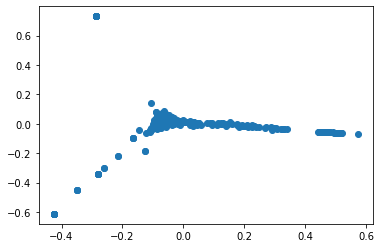

In [8]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Re-transform the bag-of-words and tf-idf from the wikipedia events dataframe
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, tokenizer=regex_tokenizer,
                             token_pattern=r'\b[1-9a-zA-Z][0-9a-zA-Z]*[#\+]{0,2}', ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(sents_list).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1]);

In [10]:

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

In [11]:

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

<Figure size 1512x900 with 0 Axes>

In [36]:

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [((data2D, None), {})]

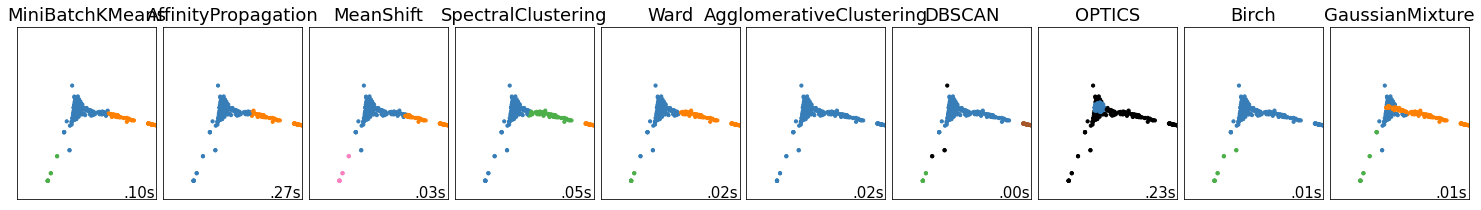

In [37]:

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 2*len(datasets) + 0.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'],
        random_state=None)
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Estimated number of clusters: 2
Estimated number of noise points: 0
Silhouette Coefficient: 0.748


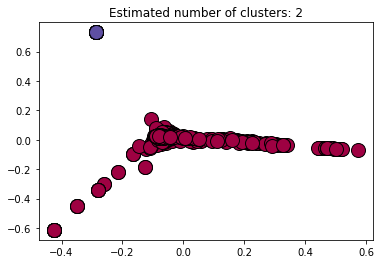

In [39]:

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(data2D)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data2D, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data2D[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data2D[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:

from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize

porter = PorterStemmer()

def clean_events_list(events_list):
    user_sentences_list = []
    for events_str in events_list:
        sentences_list = sent_tokenize(events_str)
        for sentence in sentences_list:
            user_sentences_list.append(sentence)
    
    return user_sentences_list